In [1]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from scipy.spatial.transform import Rotation
import ipympl

%matplotlib widget


In [38]:
sns.set_theme()
# LaTex must be installed for this to work
# sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{bm}')

def drop_columns_in_df(df):
    return df.drop(columns=["header.seq", "header.stamp.secs", "header.stamp.nsecs", "header.frame_id"])

def rename_columns(df, new_colum_names: list):
    column_names = ['Time'] + new_colum_names
    
    df.columns= column_names

    return df

def normalize_df_time(df):
    start_time = df['Time'].iloc[0]

    df['Time'] -= start_time

    return df

def sync_dfs_based_on_time(dataframes: list):
    df_merged = reduce(lambda left,right: pd.merge_asof(left, right, on="Time", allow_exact_matches=True, direction="nearest", tolerance=0.01), dataframes)

    return df_merged

def df_from_pose_to_euler(df):
    quat_df = df[['pose.orientation.x', 'pose.orientation.y', 'pose.orientation.z', 'pose.orientation.w']]
    rot = Rotation.from_quat(quat_df)
    rot_euler = rot.as_euler('xyz', degrees=True)
    euler_df = pd.DataFrame(data=rot_euler, columns=['roll', 'pitch', 'yaw'])

    conc = [df, euler_df]

    df_gt_euler = pd.concat(
        conc,
        axis=1,
        join="outer",
        ignore_index=False,
        keys=None,
        levels=None,
        names=None,
        verify_integrity=False,
        copy=True,
    )

    df_gt_euler = drop_columns_in_df(df_gt_euler)
    df_gt_euler.drop(columns=["pose.position.x", "pose.position.y", "pose.position.z", "pose.orientation.x", "pose.orientation.y","pose.orientation.z","pose.orientation.w"], inplace=True)

    return df_gt_euler

def Mask_Or_Drop_Successive_Identical_Values(df, drop=False, 
                                             keep_first=True,
                                             axis=0):

    '''
    Input:
    df should be a pandas.DataFrame of a a pandas.Series
    Output:
    df of ts with masked or dropped values
    '''
    
    # Mask keeping the first occurrence
    if keep_first:
        df = df.mask(df.shift(1) == df)
    # Mask including the first occurrence
    else:
        df = df.mask((df.shift(1) == df) | (df.shift(-1) == df))

    # Drop the values (e.g. rows are deleted)    
    if drop:
        return df.dropna(axis=axis)        
    # Only mask the values (e.g. become 'NaN')
    else:
        return df

def get_np_arr_without_nan(df, datacols_list, remove_identicals=True):
    if remove_identicals:
      df_with_NAN = Mask_Or_Drop_Successive_Identical_Values(df)
    else:
      df_with_NAN = df

    column_names = ['Time'] + datacols_list

    selected_rows = df_with_NAN[~df_with_NAN[datacols_list[0]].isnull()]
    reduced_df_without_NAN = selected_rows[column_names]

    return reduced_df_without_NAN.to_numpy()

In [142]:
# b = bagreader('/Users/simenallum/Library/CloudStorage/OneDrive-NTNU/Project thesis - bagfiles/lab/square/no_perception/2022-11-08-11-56-31.bag')
# b = bagreader('/Users/simenallum/Library/CloudStorage/OneDrive-NTNU/Project thesis - bagfiles/lab/mission/no_perception/2022-11-08-11-19-46.bag')
b = bagreader('/home/msccomputer/Downloads/2022-11-11-09-08-55.bag')
b.topic_table

[INFO]  Data folder /home/msccomputer/Downloads/2022-11-11-09-08-55 already exists. Not creating.


,Topics,Types,Message Count,Frequency
0,/anafi/attitude,geometry_msgs/QuaternionStamped,1938,33.633538
1,/anafi/gnss_location,sensor_msgs/NavSatFix,1938,33.783076
2,/anafi/gnss_ned_in_body_frame,geometry_msgs/PointStamped,1940,1165.732073
3,/anafi/height,olympe_bridge/Float32Stamped,1938,33.744752
4,/anafi/image,sensor_msgs/Image,1938,33.312715
5,/anafi/link_goodput,std_msgs/UInt16,1938,33.919679
6,/anafi/link_quality,std_msgs/UInt8,1938,33.841680
7,/anafi/ned_pose_from_gnss,geometry_msgs/PointStamped,1938,33.702724
8,/anafi/odometry,nav_msgs/Odometry,1937,22.879062
9,/anafi/optical_flow_velocities,geometry_msgs/Vector3Stamped,1938,33.806221


In [153]:
anafi_pos_from_gnss = b.message_by_topic('/anafi/ned_pose_from_gnss')
df_anafi_pos_from_gnss = pd.read_csv(anafi_pos_from_gnss)

df_anafi_pos_from_gnss = rename_columns(df_anafi_pos_from_gnss[["Time", "point.x",	"point.y",	"point.z"]], ["x", "y", "z"])

df_anafi_pos_from_gnss

,Time,x,y,z
0,1.668154e+09,0.531526,0.702554,0.101563
1,1.668154e+09,0.531526,0.702554,0.097656
2,1.668154e+09,0.531526,0.702554,0.097656
3,1.668154e+09,0.531526,0.702554,0.097656
4,1.668154e+09,0.531526,0.702554,0.097656
...,...,...,...,...
1933,1.668154e+09,1.116204,1.107416,0.500000
1934,1.668154e+09,1.116204,1.107416,0.500000
1935,1.668154e+09,1.116204,1.107416,0.500000
1936,1.668154e+09,1.116204,1.107416,0.500000


In [154]:
df_merged_anafi_pos = sync_dfs_based_on_time([df_anafi_pos_from_gnss])

df_merged_anafi_pos = normalize_df_time(df_merged_anafi_pos)

df_merged_anafi_pos

np_anafi_pos_from_gnss = get_np_arr_without_nan(df_merged_anafi_pos, ["x", "y", "z"], remove_identicals=True)

print(np_anafi_pos_from_gnss[0])
print(np_anafi_pos_from_gnss[-1])
print(len(np_anafi_pos_from_gnss))


[0.         0.53152586 0.70255426 0.10156256]
[64.49625826  1.11620427  1.10741577  0.5000002 ]
1373


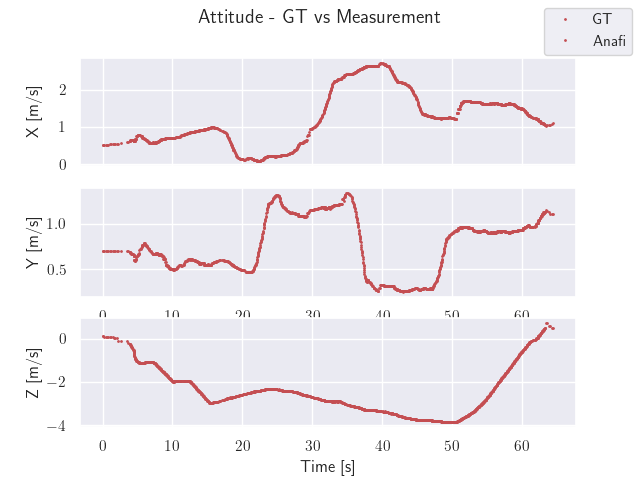

In [149]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(np_anafi_pos_from_gnss[:,0], np_anafi_pos_from_gnss[:,1],'o', ms=1, c='r')

axs[0].set_ylabel('X [m/s]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(np_anafi_pos_from_gnss[:,0], np_anafi_pos_from_gnss[:,2],'o', ms=1, c='r')

# axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m/s]')
axs[1].grid(True)
# axs[1].set_xticklabels([])



axs[2].plot(np_anafi_pos_from_gnss[:,0], np_anafi_pos_from_gnss[:,3],'o', ms=1, c='r')

axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m/s]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["GT", "Anafi"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Attitude - GT vs Measurement', fontsize=14)
fig.align_ylabels(axs)

plt.show()

# Compare GT vs Anafi attitude

In [155]:
anafi_attitude = b.message_by_topic('/anafi/pose')
df_anafi_attitude = pd.read_csv(anafi_attitude)

df_anafi_attitude = df_from_pose_to_euler(df_anafi_attitude)

df_anafi_attitude = rename_columns(df_anafi_attitude, ["anafi_roll", "anafi_pitch", "anafi_yaw"])

df_anafi_attitude


,Time,anafi_roll,anafi_pitch,anafi_yaw
0,1.668154e+09,-3.276357,7.716730,91.575527
1,1.668154e+09,-3.277094,7.716535,91.565558
2,1.668154e+09,-3.276357,7.716730,91.575527
3,1.668154e+09,-3.277831,7.716340,91.555588
4,1.668154e+09,-3.278568,7.716144,91.545618
...,...,...,...,...
1933,1.668154e+09,-3.439012,7.702853,88.151019
1934,1.668154e+09,-3.438835,7.692992,88.151252
1935,1.668154e+09,-3.438835,7.692992,88.151252
1936,1.668154e+09,-3.443730,7.687974,88.151005


In [5]:
gt_anafi_attitude = b.message_by_topic('/qualisys/Anafi/pose')
df_gt_anafi_attitude = pd.read_csv(gt_anafi_attitude)

df_gt_anafi_attitude = df_from_pose_to_euler(df_gt_anafi_attitude)
df_gt_anafi_attitude = rename_columns(df_gt_anafi_attitude, ["gt_anafi_roll", "gt_anafi_pitch", "gt_anafi_yaw"])

df_gt_anafi_attitude

,Time,gt_anafi_roll,gt_anafi_pitch,gt_anafi_yaw
0,1.677247e+09,-0.100464,-0.051751,44.330102
1,1.677247e+09,-0.126337,-0.014831,44.344189
2,1.677247e+09,-0.110999,-0.041990,44.308385
3,1.677247e+09,-0.081534,-0.159573,44.458929
4,1.677247e+09,-0.149990,0.043936,44.307562
...,...,...,...,...
3014,1.677247e+09,0.028692,0.645101,43.925046
3015,1.677247e+09,-0.040546,0.690521,43.813069
3016,1.677247e+09,-0.030187,0.773098,43.970917
3017,1.677247e+09,-0.032678,1.028433,43.818794


In [6]:
anafi_rpy = b.message_by_topic('/anafi/rpy')
df_anafi_rpy = pd.read_csv(anafi_rpy)

df_anafi_rpy['vector.x'] = np.rad2deg(df_anafi_rpy['vector.x'])
df_anafi_rpy['vector.y'] = np.rad2deg(df_anafi_rpy['vector.y'])
df_anafi_rpy['vector.z'] = np.rad2deg(df_anafi_rpy['vector.z'])

df_anafi_rpy = rename_columns(df_anafi_rpy[["Time", "vector.x", "vector.y", "vector.z"]], ["anafi_roll_rpy", "anafi_pitch_rpy", "anafi_yaw_rpy"])

df_anafi_rpy


,Time,anafi_roll_rpy,anafi_pitch_rpy,anafi_yaw_rpy
0,1.677247e+09,-0.489783,1.135009,40.193594
1,1.677247e+09,-0.489783,1.135009,40.193594
2,1.677247e+09,-0.489783,1.135009,40.193594
3,1.677247e+09,-0.489783,1.135009,40.193594
4,1.677247e+09,-0.489783,1.135009,40.193594
...,...,...,...,...
2062,1.677247e+09,-0.287747,1.801355,40.151571
2063,1.677247e+09,-0.287747,1.801355,40.151571
2064,1.677247e+09,-0.287747,1.801355,40.151571
2065,1.677247e+09,-0.287747,1.801355,40.151571


In [158]:
df_merged_attitude = sync_dfs_based_on_time([df_gt_anafi_attitude, df_anafi_attitude, df_anafi_rpy])


df_merged_attitude = normalize_df_time(df_merged_attitude)

df_merged_attitude


np_gt_anafi_attitude = get_np_arr_without_nan(df_merged_attitude, ["gt_anafi_roll",	"gt_anafi_pitch",	"gt_anafi_yaw"])
np_anafi_attitude = get_np_arr_without_nan(df_merged_attitude, ["anafi_roll",	"anafi_pitch",	"anafi_yaw"])
np_anafi_rpy = get_np_arr_without_nan(df_merged_attitude, ["anafi_roll_rpy", "anafi_pitch_rpy", "anafi_yaw_rpy"], remove_identicals=False)



[ 0.         -3.27635723  7.71673027 91.57552746]
[64.62897635 -3.4486257   7.68295562 88.15075826]
1918


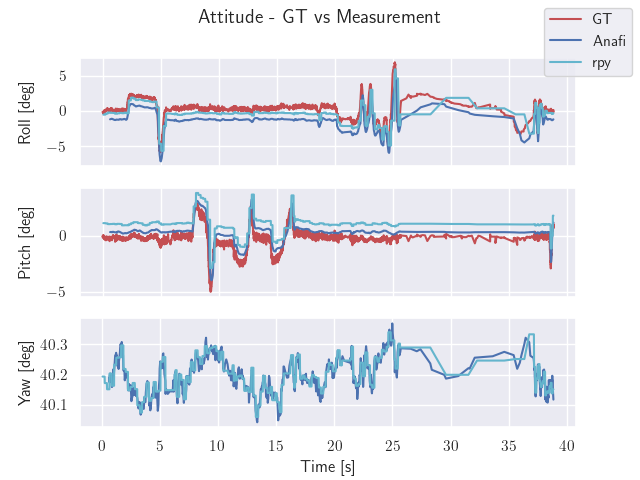

In [8]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(np_gt_anafi_attitude[:,0], np_gt_anafi_attitude[:,1],'-', ms=1, c='r')
axs[0].plot(np_anafi_attitude[:,0], np_anafi_attitude[:,1],'-', ms=1, c='b')
axs[0].plot(np_anafi_rpy[:,0], np_anafi_rpy[:,1],'-', ms=1, c='c')


axs[0].set_ylabel('Roll [deg]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(np_gt_anafi_attitude[:,0], np_gt_anafi_attitude[:,2],'-', ms=1, c='r')
axs[1].plot(np_anafi_attitude[:,0], np_anafi_attitude[:,2],'-', ms=1, c='b')
axs[1].plot(np_anafi_rpy[:,0], np_anafi_rpy[:,2],'-', ms=1, c='c')


axs[1].set_xticklabels([])
axs[1].set_ylabel('Pitch [deg]')
axs[1].grid(True)
axs[1].set_xticklabels([])



# axs[2].plot(np_gt_anafi_attitude[:,0], np_gt_anafi_attitude[:,3],'-', ms=1, c='r')
axs[2].plot(np_anafi_attitude[:,0], np_anafi_attitude[:,3],'-', ms=1, c='b')
axs[2].plot(np_anafi_rpy[:,0], np_anafi_rpy[:,3],'-', ms=1, c='c')


axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Yaw [deg]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["GT", "Anafi", "rpy"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Attitude - GT vs Measurement', fontsize=14)
fig.align_ylabels(axs)

plt.show()

# Check GT angular velocity

In [9]:
gt_anafi_odom = b.message_by_topic('/qualisys/Anafi/odom')
df_gt_anafi_odom = pd.read_csv(gt_anafi_odom)

df_gt_anafi_odom

df_gt_anafi_odom = rename_columns(df_gt_anafi_odom[["Time", "twist.twist.angular.x", "twist.twist.angular.y", "twist.twist.angular.z"]], ["angular_vel_x", "angular_vel_y", "angular_vel_z"])

df_gt_anafi_odom


,Time,angular_vel_x,angular_vel_y,angular_vel_z
0,1.677247e+09,-0.078669,0.123507,0.064748
1,1.677247e+09,-0.025824,0.057981,0.009640
2,1.677247e+09,0.045629,0.032695,0.019225
3,1.677247e+09,0.009488,-0.008085,0.023711
4,1.677247e+09,0.019628,-0.001246,-0.015235
...,...,...,...,...
3016,1.677247e+09,0.287147,0.102178,-0.011383
3017,1.677247e+09,0.231265,0.044829,-0.109584
3018,1.677247e+09,0.046745,0.024034,0.048092
3019,1.677247e+09,-0.222261,0.013312,-0.060663


In [10]:
df_merged_odom = sync_dfs_based_on_time([df_gt_anafi_odom])

df_merged_odom = normalize_df_time(df_merged_odom)

np_gt_anafi_odom = get_np_arr_without_nan(df_merged_odom, ["angular_vel_x", "angular_vel_y", "angular_vel_z"])


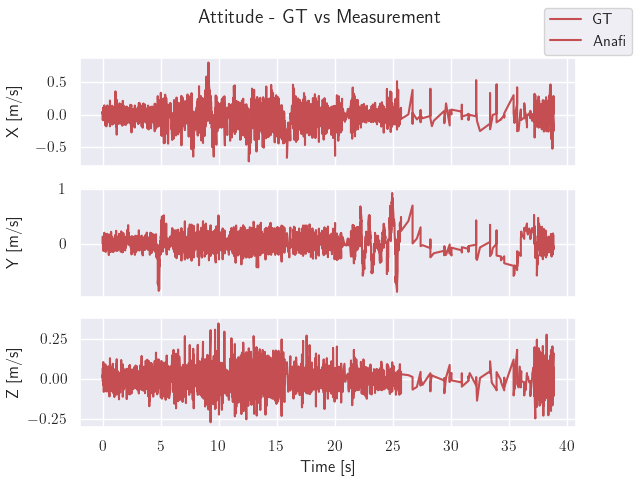

In [11]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(np_gt_anafi_odom[:,0], np_gt_anafi_odom[:,1],'-', ms=1, c='r')

axs[0].set_ylabel('X [m/s]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(np_gt_anafi_odom[:,0], np_gt_anafi_odom[:,2],'-', ms=1, c='r')

axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m/s]')
axs[1].grid(True)
axs[1].set_xticklabels([])



axs[2].plot(np_gt_anafi_odom[:,0], np_gt_anafi_odom[:,3],'-', ms=1, c='r')

axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m/s]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["GT", "Anafi"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Attitude - GT vs Measurement', fontsize=14)
fig.align_ylabels(axs)

plt.show()

# Check Anafi position

In [12]:
gt_anafi_pos = b.message_by_topic('/qualisys/Anafi/pose')
df_gt_anafi_pos = pd.read_csv(gt_anafi_pos)

df_gt_anafi_pos = rename_columns(df_gt_anafi_pos[["Time", "pose.position.x",	"pose.position.y",	"pose.position.z"]], ["gt_x", "gt_y", "gt_z"])

df_gt_anafi_pos

,Time,gt_x,gt_y,gt_z
0,1.677247e+09,0.388076,0.101900,-2.256213
1,1.677247e+09,0.388081,0.101949,-2.256166
2,1.677247e+09,0.388029,0.101884,-2.256204
3,1.677247e+09,0.388207,0.101795,-2.256437
4,1.677247e+09,0.388143,0.101968,-2.256394
...,...,...,...,...
3014,1.677247e+09,1.300215,-0.436101,-2.299710
3015,1.677247e+09,1.300763,-0.435505,-2.299703
3016,1.677247e+09,1.301159,-0.435242,-2.299461
3017,1.677247e+09,1.301724,-0.434812,-2.299533


In [ ]:
anafi_pos_from_gnss = b.message_by_topic('/anafi/ned_pos_from_gnss')
df_anafi_pos_from_gnss = pd.read_csv(anafi_pos_from_gnss)

df_anafi_pos_from_gnss = rename_columns(df_anafi_pos_from_gnss[["Time", "point.x",	"point.y",	"point.z"]], ["x", "y", "z"])

df_anafi_pos_from_gnss

In [40]:
df_merged_anafi_pos = sync_dfs_based_on_time([df_gt_anafi_pos, df_anafi_pos_from_gnss])

df_merged_anafi_pos = normalize_df_time(df_merged_anafi_pos)

df_merged_anafi_pos


np_gt_anafi_pos = get_np_arr_without_nan(df_merged_anafi_pos, ["gt_x", "gt_y", "gt_z"])
np_anafi_pos_from_gnss = get_np_arr_without_nan(df_merged_anafi_pos, ["x", "y", "z"], remove_identicals=False)

np_anafi_pos_from_gnss

,Time,gt_x,gt_y,gt_z,x,y,z
0,0.000000,0.388076,0.101900,-2.256213,NaN,NaN,NaN
1,0.010116,0.388081,0.101949,-2.256166,NaN,NaN,NaN
2,0.023703,0.388029,0.101884,-2.256204,NaN,NaN,NaN
3,0.029036,0.388207,0.101795,-2.256437,NaN,NaN,NaN
4,0.038084,0.388143,0.101968,-2.256394,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3014,38.817042,1.300215,-0.436101,-2.299710,NaN,NaN,NaN
3015,38.838159,1.300763,-0.435505,-2.299703,NaN,NaN,NaN
3016,38.838168,1.301159,-0.435242,-2.299461,NaN,NaN,NaN
3017,38.838180,1.301724,-0.434812,-2.299533,NaN,NaN,NaN


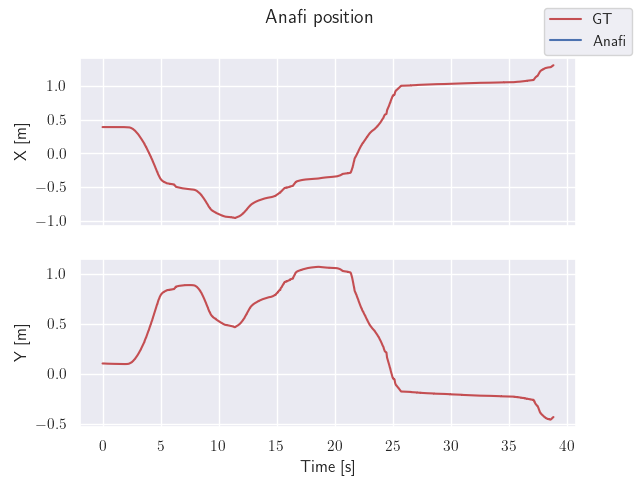

In [39]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(np_gt_anafi_pos[:,0], np_gt_anafi_pos[:,1],'-', ms=1, c='r')
axs[0].plot(np_anafi_pos_from_gnss[:,0], np_anafi_pos_from_gnss[:,1],'-', ms=1, c='b')


axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(np_gt_anafi_pos[:,0], np_gt_anafi_pos[:,2],'-', ms=1, c='r')
axs[1].plot(np_anafi_pos_from_gnss[:,0], np_anafi_pos_from_gnss[:,2],'o', ms=2, c='b')


axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)

handles, labels = axs[1].get_legend_handles_labels()
labels = ["GT", "Anafi"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Anafi position', fontsize=14)
fig.align_ylabels(axs)

plt.show()

# Evaluate algorithm

In [138]:
tracks_coord = b.message_by_topic('/search/tracks/world_coordinates')
df_tracks_coord = pd.read_csv(tracks_coord)

df_tracks_coord = df_tracks_coord[["Time", "x", "y", "z"]]

df_tracks_coord

,Time,x,y,z
0,1.677490e+09,0.419086,0.119969,0.000000e+00
1,1.677490e+09,0.418968,0.120062,0.000000e+00
2,1.677490e+09,0.418904,0.120379,0.000000e+00
3,1.677490e+09,0.418898,0.120314,4.440892e-16
4,1.677490e+09,0.418828,0.120513,4.440892e-16
...,...,...,...,...
989,1.677490e+09,0.480289,0.107619,0.000000e+00
990,1.677490e+09,0.480289,0.107619,0.000000e+00
991,1.677490e+09,0.479619,0.107884,4.440892e-16
992,1.677490e+09,0.480490,0.106971,4.440892e-16


In [139]:

gt_track_coord = b.message_by_topic('/qualisys/AT0/pose')
df_gt_track_coord = pd.read_csv(gt_track_coord)

df_gt_track_coord = rename_columns(df_gt_track_coord[["Time", "pose.position.x",	"pose.position.y",	"pose.position.z"]], ["gt_x", "gt_y", "gt_z"])

df_gt_track_coord

,Time,gt_x,gt_y,gt_z
0,1.677490e+09,0.471049,0.190781,-0.014402
1,1.677490e+09,0.471041,0.190767,-0.014390
2,1.677490e+09,0.471033,0.190767,-0.014430
3,1.677490e+09,0.471076,0.190801,-0.014469
4,1.677490e+09,0.471027,0.190764,-0.014392
...,...,...,...,...
3273,1.677490e+09,0.471018,0.190805,-0.014362
3274,1.677490e+09,0.471038,0.190735,-0.014405
3275,1.677490e+09,0.471024,0.190782,-0.014451
3276,1.677490e+09,0.471018,0.190729,-0.014436


In [140]:
df_merged_track_coord = sync_dfs_based_on_time([df_tracks_coord, df_gt_track_coord])

df_merged_track_coord = normalize_df_time(df_merged_track_coord)

df_merged_track_coord


np_gt_track_coord = get_np_arr_without_nan(df_merged_track_coord, ["gt_x", "gt_y", "gt_z"])
np_track_coord = get_np_arr_without_nan(df_merged_track_coord, ["x", "y", "z"])

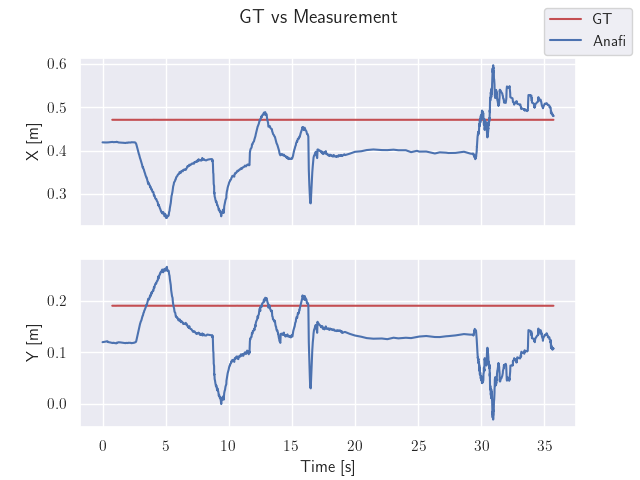

In [141]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(np_gt_track_coord[:,0], np_gt_track_coord[:,1],'-', ms=1, c='r')
axs[0].plot(np_track_coord[:,0], np_track_coord[:,1],'-', ms=1, c='b')

axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(np_gt_track_coord[:,0], np_gt_track_coord[:,2],'-', ms=1, c='r')
axs[1].plot(np_track_coord[:,0], np_track_coord[:,2],'-', ms=1, c='b')

axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)

handles, labels = axs[1].get_legend_handles_labels()
labels = ["GT", "Anafi"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('GT vs Measurement', fontsize=14)
fig.align_ylabels(axs)

plt.show()

# Camera coordinates

In [123]:

camera_coordinates_tria = b.message_by_topic('/search/tracks/camera_coordinates_tria')
df_camera_coordinates_tria = pd.read_csv(camera_coordinates_tria)

df_camera_coordinates_tria = rename_columns(df_camera_coordinates_tria[["Time", "x", "y", "z"]], ["x_tria", "y_tria", "z_tria"])

df_camera_coordinates_tria

,Time,x_tria,y_tria,z_tria
0,1.677490e+09,-0.022944,-0.049240,2.255478
1,1.677490e+09,-0.022944,-0.049238,2.255401
2,1.677490e+09,-0.022942,-0.049235,2.255273
3,1.677490e+09,-0.022944,-0.049238,2.255411
4,1.677490e+09,-0.022945,-0.049240,2.255496
...,...,...,...,...
989,1.677490e+09,1.002146,0.324112,2.296942
990,1.677490e+09,1.002146,0.324112,2.296942
991,1.677490e+09,1.001907,0.324433,2.299217
992,1.677490e+09,1.000674,0.324433,2.299217


In [124]:
camera_coordinates_fov = b.message_by_topic('/search/tracks/camera_coordinates_fov')
df_camera_coordinates_fov = pd.read_csv(camera_coordinates_fov)

df_camera_coordinates_fov = rename_columns(df_camera_coordinates_fov[["Time", "x", "y", "z"]], ["x_fov", "y_fov", "z_fov"])

df_camera_coordinates_fov

,Time,x_fov,y_fov,z_fov
0,1.677490e+09,-0.007427,-0.035827,2.255478
1,1.677490e+09,-0.007427,-0.035826,2.255401
2,1.677490e+09,-0.007427,-0.035824,2.255273
3,1.677490e+09,-0.007427,-0.035826,2.255411
4,1.677490e+09,-0.007427,-0.035827,2.255496
...,...,...,...,...
989,1.677490e+09,0.940325,0.323394,2.296942
990,1.677490e+09,0.940325,0.323394,2.296942
991,1.677490e+09,0.939994,0.323714,2.299217
992,1.677490e+09,0.938732,0.323714,2.299217


In [126]:
df_merged_track_camera_coord = sync_dfs_based_on_time([df_camera_coordinates_fov, df_camera_coordinates_tria])

df_merged_track_camera_coord = normalize_df_time(df_merged_track_camera_coord)


np_camera_coordinates_tria = get_np_arr_without_nan(df_merged_track_camera_coord, ["x_tria", "y_tria", "z_tria"], remove_identicals=False)
np_camera_coordinates_fov = get_np_arr_without_nan(df_merged_track_camera_coord, ["x_fov", "y_fov", "z_fov"], remove_identicals=False)

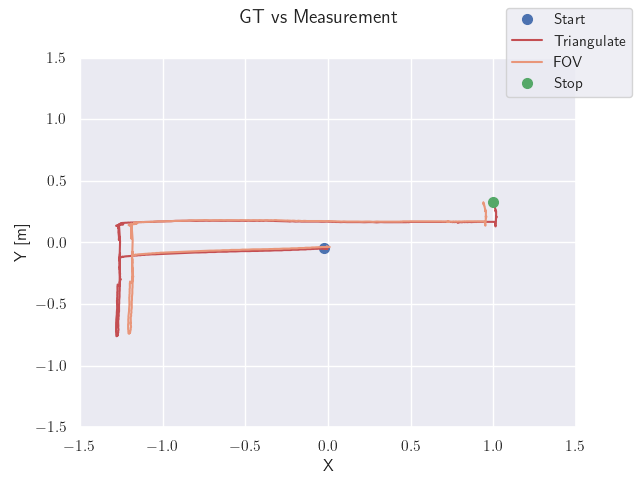

In [127]:
fig = plt.figure()

plt.plot(np_camera_coordinates_tria[0,1], np_camera_coordinates_tria[0,2],'o', ms=7, c='b')
plt.plot(np_camera_coordinates_tria[:,1], np_camera_coordinates_tria[:,2],'-', ms=1, c='r')
plt.plot(np_camera_coordinates_fov[:,1], np_camera_coordinates_fov[:,2],'-', ms=1, c='darksalmon')
plt.plot(np_camera_coordinates_tria[-1,1], np_camera_coordinates_tria[-1,2],'o', ms=7, c='g')

plt.xlabel("X")
plt.ylabel('Y [m]')
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
labels = ["Start", "Triangulate", "FOV", "Stop"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('GT vs Measurement', fontsize=14)
fig.align_ylabels(axs)